### Cab-Driver Agent

In [1]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle
import time

# for plotting graphs
import matplotlib.pyplot as plt

# Import the environment
from Env3 import CabDriver
env = CabDriver()

In [2]:
# for building DQN model
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.optimizers import Adam

2022-01-25 07:30:21.490862: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-25 07:30:21.490885: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
import tensorflow.compat.v1 as tf

tf.disable_v2_behavior()
jobs = 8
config = tf.ConfigProto(intra_op_parallelism_threads = jobs, inter_op_parallelism_threads=jobs, 
                        allow_soft_placement = True,
                        device_count={'CPU':jobs})
session = tf.Session(config=config)

from tensorflow.compat.v1.keras import backend as K
K.set_session(session)

Instructions for updating:
non-resource variables are not supported in the long term


2022-01-25 07:30:25.366380: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-25 07:30:25.368690: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-01-25 07:30:25.368723: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-01-25 07:30:25.368745: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Kamna): /proc/driver/nvidia/version does not exist


#### Defining Time Matrix

Note on location numbering:
- The states (locations) at which the cab driver can be located are numbered from 1 to 5 in our MDP.
- This is contrary to how it is defined in the Time Matrix, where the locations are numbered 0 to 4. 
- Hence, we use the MDP definition of the location numbering, but subtract '1' from it whenever the Time Matrix needs to be referred.

In [6]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")

In [7]:
Time_matrix.shape

(5, 5, 24, 7)

In [8]:
Time_matrix[1,4,:,5]

array([1., 1., 1., 1., 1., 1., 5., 5., 5., 5., 5., 5., 0., 0., 0., 0., 0.,
       0., 2., 2., 2., 2., 2., 2.])

In [9]:
print(type(Time_matrix))
print(Time_matrix.max())
print(Time_matrix.min())
print(Time_matrix.mean())
print(Time_matrix.var())

<class 'numpy.ndarray'>
11.0
0.0
3.0542857142857143
7.93705306122449


### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [10]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # Write here: Specify you hyper parameters for the DQN
        self.discount_factor = 0.95
        self.learning_rate = 0.001       
        self.epsilon = 1
        self.epsilon_max = 1
        self.epsilon_decay = 0.0003
        self.epsilon_min = 0.00001
              
        self.batch_size = 32        
        
        # create replay memory using deque
        self.memory = deque(maxlen=2000)
        
        # Initialize the value of the states tracked
        self.states_tracked = []
        self.track_state = np.array(env.state_encod_arch1([1,0,0])).reshape(1, 36)
        
        # create main model and target model
        self.model = self.build_model()

    # approximate Q function using Neural Network
    def build_model(self):
        
        model = Sequential()
        
        # Write your code here: Add layers to your neural nets       
        model.add(Dense(32, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(self.action_size, activation='relu', kernel_initializer='he_uniform'))
        
        model.compile(loss='mse',optimizer=Adam(learning_rate=self.learning_rate))
        model.summary
        
        return model

    
    def get_action(self, state, action_space, possible_actions_index):
        # Write your code here:
        # get action from model using epsilon-greedy policy
        # Decay in ε after we generate each sample from the environment       
        
        if np.random.rand() <= self.epsilon:
            # explore: choose a random action from all possible actions
            # return random.choice(possible_actions_index)
            
            index = random.randrange(len(possible_actions_index))
            action_index = possible_actions_index[index]
            action = action_space[action_index]
            return action_index, action
    
        else:
            # choose the action with the highest q(s, a)
            # the first index corresponds to the batch size, so reshape state to (1, state_size) 
            # so that the first index corresponds to the batch size
            
            state = np.array(state).reshape(1, self.state_size)

            # Use the model to predict the Q_values.
            q_value = self.model.predict(state)

            #return possible_actions_index[np.argmax(q_vals_possible)]
            return np.argmax(q_value[0]), action_space[np.argmax(q_value[0])]

    def append_sample(self, state, action, reward, next_state):
        # Write your code here:
        # save sample <s,a,r,s'> to the replay memory
        self.memory.append((state, action, reward, next_state))
    
    
    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):
        
        if len(self.memory) > self.batch_size:
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
            update_output = np.zeros((self.batch_size, self.state_size)) # write here
            update_input = np.zeros((self.batch_size, self.state_size)) # write here
            
            actions, rewards = [], []
            
            for i in range(self.batch_size):
                state, action, reward, next_state = mini_batch[i]
                update_input[i] = state
                actions.append(action)
                rewards.append(reward)
                update_output[i] = next_state
                
            # Write your code from here
            
            # 1. Predict the target from earlier model
            target = self.model.predict(update_input)
                
            # 2. Get the target for the Q-network
            target_qval = self.model.predict(update_output)
                
            #3. Update your 'update_output' and 'update_input' batch
            for i in range(self.batch_size):
                target[i][actions[i]] = rewards[i] + self.discount_factor * np.max(target_qval[i])
                
            # 4. Fit your model and track the loss values
            self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)
    
    def store_q_values(self):
        # Use the model to predict the q_value of the state we are tacking.
        q_value = self.model.predict(self.track_state)
        
        # Grab the q_value of the action index that we are tracking. Action = (1,3). 
        # See note earlier about difference between location numbering in MDP and Time Matrix
        self.states_tracked.append(q_value[0][2])
    
    #Defining a function to save the model weights to a pickle file
    def save_weights(self, name):
        with open(name + '.pkl', 'wb') as f:
            pickle.dump(self.model.get_weights(), f, pickle.HIGHEST_PROTOCOL)
    
    # Defining a function to save the model itself at regular intervals.
    def save_model(self, model_name):
        self.model.save(model_name)

In [11]:
Episodes = 20000

### DQN block

In [12]:
# Intitialise some variables for use in tracking rewards
rewards_per_episode, episodes, avg_rewards_per_episode = [], [], []

# Initialise the agent
env = CabDriver()
agent = DQNAgent(state_size=len(env.state_encod_arch1(env.state_init)), action_size=len(env.action_space))

# Since the car has to be recharged every 30 days, defining max episode duration
episode_time = 24*30 

In [13]:
start_time = time.time()
for episode in range(1,Episodes+1):

    # Write code here
    # Call the environment
    env = CabDriver()
    
    score = 0           # to calculate rewards for current episode
    total_time = 0      # to calculate total time during current episode.
    
    done = False        # to keep track of end of episode
         
    # Call all the initialised variables of the environment
    action_space, state_space, state = env.reset()
            
    #Call the DQN agent
    #agent = DQNAgent(action_size=len(action_space), state_size=len(env.state_encod_arch1(env.state_init)))
    
    while not done:
        
        # Write your code here
               
        # 1. Pick epsilon-greedy action from possible actions for the current state
        
        possible_actions_index, actions = env.requests(state)
        action_index, action = agent.get_action(env.state_encod_arch1(state), env.action_space, possible_actions_index)
        
        # 2. Evaluate your reward and next state
        next_state, wait_time, transit_time, ride_time = env.next_state_func(state, action, Time_matrix)
        reward = env.reward_func(state, action, Time_matrix)
        step_time = wait_time + transit_time + ride_time
        
        # 3. Append the experience to the memory
        total_time += step_time
        
        agent.append_sample(env.state_encod_arch1(state), action_index,reward, env.state_encod_arch1(next_state))
        
        
        # 4. Train the model by calling function agent.train_model
        if (episode - 1) % 20 == 0:      # Training every 20 episodes to reduce runtimes
            agent.train_model()
        
        # 5. Keep a track of rewards, Q-values, loss
        score += reward
        state = next_state
                
        if total_time >= episode_time:
            done = True                  # End of episode
        
    # store total reward obtained in this episode
    rewards_per_episode.append(score)
    episodes.append(episode)
    
    # epsilon decay
    if agent.epsilon > agent.epsilon_min:
        agent.epsilon = agent.epsilon_min + (agent.epsilon_max - agent.epsilon_min) * np.exp(-agent.epsilon_decay*episode)
            
    # Save the Q_value of the state, action pair we are tracking
    if (episode % 20 == 0):
        agent.store_q_values()
    
    # Save model and model weights at regular intervals.
    
    if((episode) % 200 == 0):
        print("Episode {0},\tReward {1},\t Memory_length {2},\t epsilon {3},\t Total_time {4}".format(episode,score,len(agent.memory),agent.epsilon, total_time))
        
        print("Saving Model weights at episode {}".format(episode))
        agent.save_weights(name = './Model_Weights/model_9_weights_at_episode' + str(episode))      
    
    if((episode) % 1000 == 0):
        print("Saving Model at episode {}".format(episode))
        agent.save_model(model_name="./Models/model_9_at_episode" + str(episode) + ".h5")
     
agent.save_model(model_name="./Models/model_9_final.h5")  
agent.save_weights(name = './Model_Weights/model_9_weights_final')

/home/siddhant/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '
2022-01-25 07:30:56.094992: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2594055000 Hz


Episode 200,	Reward -63.0,	 Memory_length 2000,	 epsilon 0.9417651159389129,	 Total_time 720.0
Saving Model weights at episode 200
Episode 400,	Reward -103.0,	 Memory_length 2000,	 epsilon 0.8869215675127903,	 Total_time 728.0
Saving Model weights at episode 400
Episode 600,	Reward 526.0,	 Memory_length 2000,	 epsilon 0.8352718587091579,	 Total_time 721.0
Saving Model weights at episode 600
Episode 800,	Reward 571.0,	 Memory_length 2000,	 epsilon 0.7866299947879428,	 Total_time 721.0
Saving Model weights at episode 800
Episode 1000,	Reward 787.0,	 Memory_length 2000,	 epsilon 0.740820812499511,	 Total_time 721.0
Saving Model weights at episode 1000
Saving Model at episode 1000
Episode 1200,	Reward 621.0,	 Memory_length 2000,	 epsilon 0.6976793493077703,	 Total_time 720.0
Saving Model weights at episode 1200
Episode 1400,	Reward 380.0,	 Memory_length 2000,	 epsilon 0.6570502493468586,	 Total_time 725.0
Saving Model weights at episode 1400
Episode 1600,	Reward 1004.0,	 Memory_length 2000

### Tracking Convergence

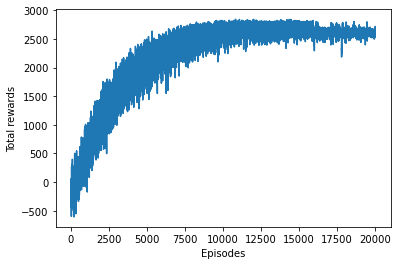

In [14]:
# Check Convergence by tracking total rewards per episode vs episode number
plt.plot(list(range(len(rewards_per_episode))), rewards_per_episode)
plt.ylabel("Total rewards")
plt.xlabel("Episodes")
plt.show()

In [15]:
# Average reward per 100 episode to view the general trend

avg_rewards = []
episodes = len(rewards_per_episode)
index = 0
track_total_reward = 0
for episode_number in range(Episodes):
    if index != 100:
        track_total_reward += rewards_per_episode[episode_number]
        index += 1
    else:
        avg_rewards.append(track_total_reward/index)
        track_total_reward = rewards_per_episode[episode_number]
        index = 1

avg_rewards.append(track_total_reward/index)
        
    
print(avg_rewards)

[-120.34, -86.2, -35.18, 21.23, 95.07, 125.46, 248.49, 343.72, 330.91, 504.09, 539.69, 551.81, 652.55, 769.34, 784.99, 938.67, 939.81, 931.76, 1001.92, 1120.14, 1115.75, 1170.58, 1185.4, 1243.26, 1309.73, 1346.42, 1395.5, 1398.75, 1478.25, 1522.2, 1516.89, 1589.02, 1605.65, 1682.73, 1699.44, 1711.01, 1721.11, 1760.24, 1837.57, 1824.04, 1889.12, 1899.14, 1907.76, 1954.09, 1922.93, 1981.52, 2007.16, 1984.75, 2046.69, 2065.89, 2058.3, 2066.41, 2083.06, 2154.61, 2162.94, 2165.89, 2190.97, 2213.78, 2237.27, 2231.42, 2249.66, 2298.54, 2274.64, 2267.7, 2291.46, 2316.23, 2355.41, 2367.41, 2376.54, 2390.18, 2397.56, 2418.01, 2442.96, 2446.41, 2452.69, 2447.3, 2462.6, 2437.99, 2479.18, 2463.62, 2496.63, 2480.78, 2519.24, 2528.53, 2514.34, 2541.93, 2533.18, 2539.74, 2548.18, 2538.95, 2579.03, 2588.82, 2585.03, 2549.76, 2580.1, 2613.87, 2596.76, 2600.83, 2622.63, 2623.1, 2635.39, 2610.1, 2601.54, 2635.9, 2639.41, 2614.81, 2631.32, 2636.3, 2645.84, 2644.15, 2665.21, 2639.75, 2677.44, 2637.78, 2620.

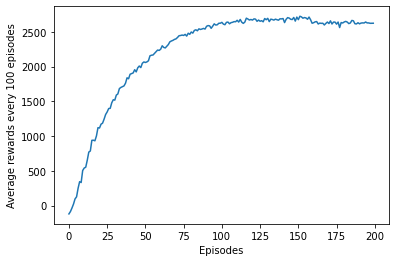

In [16]:
## Check Convergence by tracking average rewards per episode vs episode number
plt.plot(list(range(len(avg_rewards))), avg_rewards)
plt.ylabel("Average rewards every 100 episodes")
plt.xlabel("Episodes")
plt.show()

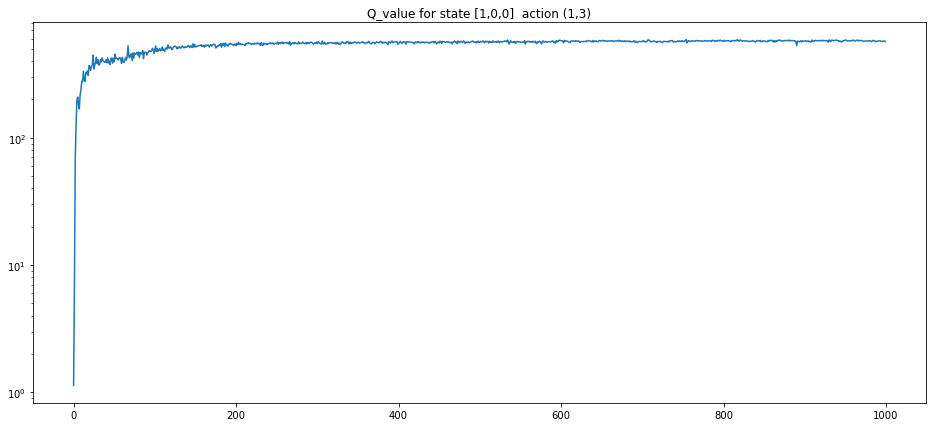

In [17]:
plt.figure(0, figsize=(16,7))
plt.title('Q_value for state [1,0,0]  action (1,3)')
xaxis = np.asarray(range(0, len(agent.states_tracked)))
plt.semilogy(xaxis,np.asarray(agent.states_tracked))
plt.show()

#### Epsilon-decay sample function

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

In [27]:
time = np.arange(0,20000)
epsilon = []
for i in range(0,20000):
    epsilon.append(0.00001 + (1 - 0.00001) * np.exp(-0.0003*i))

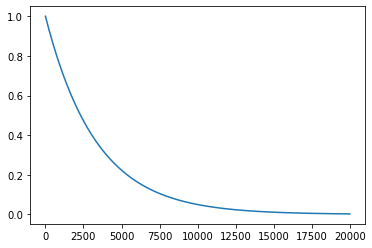

In [28]:
plt.plot(time, epsilon)
plt.show()